In [56]:
import pandas as pd
import numpy as np
import matplotlib as plt
import pandas_profiling

In [57]:
df = pd.read_csv('./raw_data/train.csv')
test_df = pd.read_csv('./raw_data/test.csv')
combined = [df, test_df]

In [58]:
df.shape

(8693, 14)

In [59]:
test_df.shape

(4277, 13)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


#### -PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
#### -HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
#### -CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
#### -Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
#### -Destination - The planet the passenger will be debarking to.
#### -Age - The age of the passenger.
#### -VIP - Whether the passenger has paid for special VIP service during the voyage.
#### -RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
#### -Name - The first and last names of the passenger.
#### -Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. ###

In [61]:
df['private_amenities_combined'] = df.RoomService + df.Spa + df.VRDeck
# Amenities where person spent more money on activities done while most likely alone or out of the view of the public
# and not out and about seem to have a higher correlation with those transported than those who spent more money doing stuff out in the open
# multiplying these features together does not create a stronger correlation with the transported feature, but adding them does.

In [76]:
df.corr(method='pearson')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,private_amenities_combined
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026,0.163301
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611,0.362251
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566,0.270936
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141,0.026897
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131,0.716882
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075,0.688745
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000,-0.356140
private_amenities_combined,0.163301,0.362251,0.270936,0.026897,0.716882,0.688745,-0.356140,1.000000


In [63]:
non_null_cryo = 8476
ratio_true =  (df.CryoSleep[(df.CryoSleep == True)].count() / non_null_cryo) * 100
ratio_false =  (df.CryoSleep[(df.CryoSleep == False)].count() / non_null_cryo) * 100

In [64]:
print(ratio_true)


35.8305804624823


In [65]:
print(ratio_false)

64.1694195375177


#### Can maybe conclude that training data had 35.83% of sample size were in CryoSleep & 64.17% were not. Can use this ratio to fill in the missing data points?


#### Will now assess the test data to see if the proportion is similar

##### 4277 Total entries, 4184 are not-null.

In [66]:
test_ratio_true =  (test_df.CryoSleep[(test_df.CryoSleep == True)].count() / 4184) * 100
test_ratio_false =  (test_df.CryoSleep[(test_df.CryoSleep == False)].count() / 4184) * 100

In [67]:
print(test_ratio_true)

36.90248565965583


In [68]:
print(test_ratio_false)

63.09751434034416


##### Looks like both testing and the training datasets have a proportion of ~ 36% "True", and 64% "False" values for the not null CryoSleep data. I could use this ratio to fill the remaining n Null datapoints.

## May need to investigate age correlation...perhaps bands of age would be more important? Young vs Old or certain age ranges.

<AxesSubplot:ylabel='Frequency'>

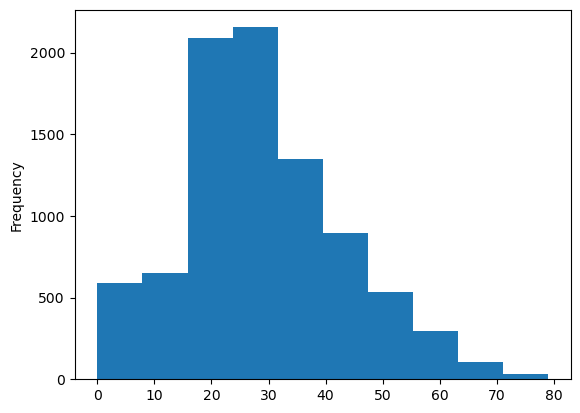

In [143]:
dff = (df[df.Transported == True])
dff
df.Age.plot(kind='hist')

In [144]:
# Age Bands = >=0 -- < 20, >=20 -- <= 40, >40 -- <=60, >60 are the age ranges that I think I want to create based 
# on the histogram of transported people. These will then be categorical, 0-1-2-3 group values.
# dff.Age[(dff.Age > 0) & (dff.Age < 20)].count()
# dff.Age[(dff.Age >= 20) & (dff.Age < 40)].count()
# dff.Age[dff.Age >= 60].count()
# dff.Age[(dff.Age >= 40) & (dff.Age < 60)].count()

In [138]:
#mean age is 28, using that to fill NA, applicable to test and training data.
df.Age = df.Age.fillna(28)
test_df.Age = test_df.Age.fillna(28)

In [148]:
df.Destination.isnull().value_counts()

False    8511
True      182
Name: Destination, dtype: int64

## I have about 182 missing values for destination. Right now destination needs to be converted to a categorical variable and I need to address the missing data

<AxesSubplot:>

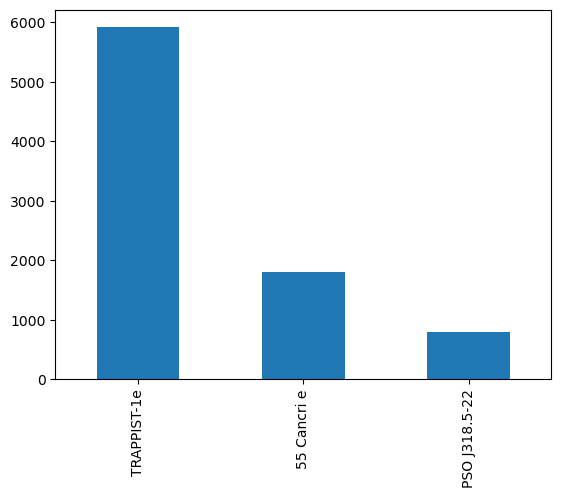

In [158]:
df.Destination.value_counts().plot(kind='bar')

<AxesSubplot:>

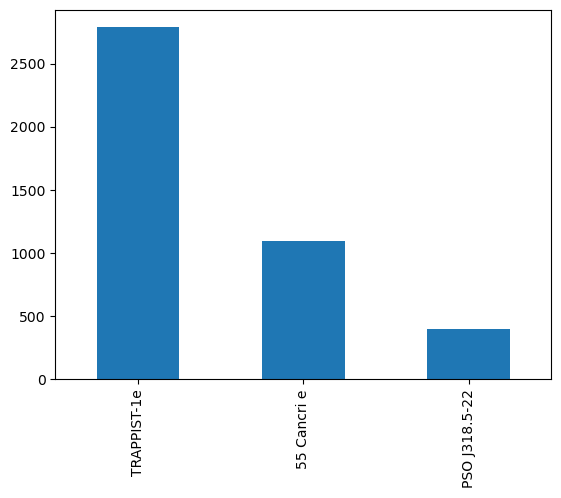

In [159]:
dff.Destination.value_counts().plot(kind='bar')

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PassengerId                 8693 non-null   object 
 1   HomePlanet                  8492 non-null   object 
 2   CryoSleep                   8476 non-null   object 
 3   Cabin                       8494 non-null   object 
 4   Destination                 8511 non-null   object 
 5   Age                         8693 non-null   float64
 6   VIP                         8490 non-null   object 
 7   RoomService                 8512 non-null   float64
 8   FoodCourt                   8510 non-null   float64
 9   ShoppingMall                8485 non-null   float64
 10  Spa                         8510 non-null   float64
 11  VRDeck                      8505 non-null   float64
 12  Name                        8493 non-null   object 
 13  Transported                 8693 